   Torque [Nm]  Tool wear [min]  rf_proba  anomaly_flag  risk_score  \
0         42.8                0       0.0             0    0.000000   
1         46.3                3       0.0             0    0.003557   
2         49.4                5       0.0             0    0.005929   
3         39.5                7       0.0             0    0.008300   
4         40.0                9       0.0             0    0.010672   

   risk_label  
0  Unkritisch  
1  Unkritisch  
2  Unkritisch  
3  Unkritisch  
4  Unkritisch  


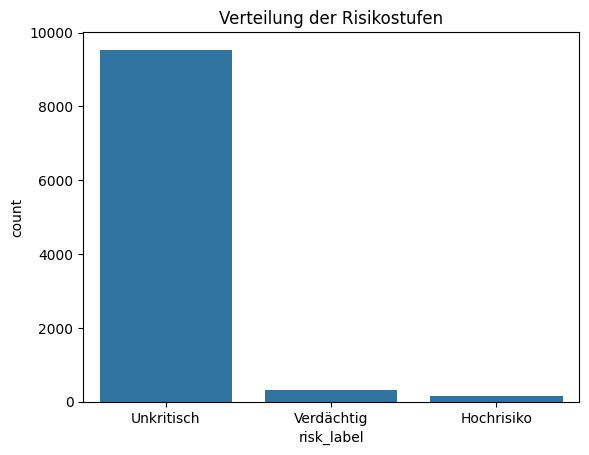

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split

# Daten laden
df = pd.read_csv('../data/ai4i2020.csv')

# --------------------
# 1. Vorbereitung
# --------------------
# Ziel
y = df['Machine failure']

# Feature-Set
features = ['Torque [Nm]', 'Tool wear [min]', 'Rotational speed [rpm]', 'Process temperature [K]', 'Type']
X = pd.get_dummies(df[features], drop_first=True)

# Train/Test-Split (wir nutzen hier 100% fürs Training – Ziel ist Risikoindikator, nicht Testbewertung)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Machine Failure Wahrscheinlichkeit
df['rf_proba'] = rf.predict_proba(X)[:, 1]

# Isolation Forest
iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(X)
df['anomaly_flag'] = (df['anomaly'] == -1).astype(int)

# --------------------
# 2. Fehlerindikator berechnen
# --------------------
# Skaliere Tool wear (0–1)
df['tool_wear_scaled'] = (df['Tool wear [min]'] - df['Tool wear [min]'].min()) / (df['Tool wear [min]'].max() - df['Tool wear [min]'].min())

# Kombinierter Risiko-Score (gewichteter Mittelwert)
df['risk_score'] = (
    0.5 * df['rf_proba'] +
    0.3 * df['tool_wear_scaled'] +
    0.2 * df['anomaly_flag']
)

# --------------------
# 3. Risikostatus zuweisen
# --------------------
def classify_risk(score):
    if score < 0.3:
        return 'Unkritisch'
    elif score < 0.6:
        return 'Verdächtig'
    else:
        return 'Hochrisiko'

df['risk_label'] = df['risk_score'].apply(classify_risk)

# --------------------
# 4. Ergebnisse anzeigen
# --------------------
print(df[['Torque [Nm]', 'Tool wear [min]', 'rf_proba', 'anomaly_flag', 'risk_score', 'risk_label']].head())

# Optional: Verteilung anzeigen
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='risk_label', data=df, order=['Unkritisch', 'Verdächtig', 'Hochrisiko'])
plt.title("Verteilung der Risikostufen")
plt.show()
